In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets, optimizers, losses
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

print("Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")


Libraries imported successfully.
TensorFlow Version: 2.18.0
Keras Version: 3.8.0


In [5]:

# Check for GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU available: {gpu_devices}")
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth configured.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available, using CPU.")


GPU not available, using CPU.


In [7]:
BATCH_SIZE = 64          # Number of images per batch
LEARNING_RATE = 0.001    # Learning rate for the optimizer
NUM_EPOCHS = 500         # Number of times to iterate over the entire dataset
NUM_CLASSES = 100        # CIFAR-100 has 100 classes
INPUT_SHAPE = (32, 32, 3) # CIFAR images are 32x32 pixels with 3 color channels (RGB)
L2_LAMBDA = 0.0002      # L2 regularization strength

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Input Shape: {INPUT_SHAPE}")

Configuration:
  Batch Size: 64
  Learning Rate: 0.001
  Number of Epochs: 500
  Number of Classes: 100
  Input Shape: (32, 32, 3)


In [13]:
# Load the dataset directly using `tf.keras.datasets.cifar100`.
# This function returns NumPy arrays for training and testing images and labels.
# - Images (`x_train`, `x_test`) are NumPy arrays of shape (num_samples, 32, 32, 3) with pixel values in [0, 255].
# - Labels (`y_train`, `y_test`) are NumPy arrays of shape (num_samples, 1) containing integer labels from 0 to 99.

print("Loading CIFAR-100 dataset...")
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()


Loading CIFAR-100 dataset...


In [11]:

print("Dataset loaded successfully.")
print(f"  x_train shape: {x_train.shape}") # (50000, 32, 32, 3)

Dataset loaded successfully.


NameError: name 'x_train' is not defined

In [9]:
# x_train holds 50,000 images. Each of those 50,000 images is a 32x32 grid of pixels.
# And at each of those 32x32 pixel locations, there are 3 values representing the
# Red, Green, and Blue color components of that pixel.

print(f"  y_train shape: {y_train.shape}") # (50000, 1)
print(f"  x_test shape: {x_test.shape}")   # (10000, 32, 32, 3)
print(f"  y_test shape: {y_test.shape}")   # (10000, 1)
print(f"  Number of training samples: {x_train.shape[0]}")
print(f"  Number of test samples: {x_test.shape[0]}")
print(f"  Image data type: {x_train.dtype}") # uint8
print(f"  Label data type: {y_train.dtype}") # int64
print(f"  Min/Max pixel values: {x_train.min()}/{x_train.max()}") # 0/255


NameError: name 'y_train' is not defined

In [8]:
# Prepare the data for training:
# - Convert Image Type: Change image data type from `uint8` to `float32` for calculations.
# - Normalize Pixels: Scale pixel values from the range [0, 255] to [0, 1]. This helps stabilize training. Alternatively, you could scale to [-1, 1] by dividing by 127.5 and subtracting 1.
# - Labels: The labels are already integers (0-99), which is the format expected by `SparseCategoricalCrossentropy` loss. No changes needed for `y_train`, `y_test`.

# Convert image data types to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0

print(f"  x_train data type after conversion: {x_train.dtype}") # float32
print(f"  Min/Max pixel values after normalization: {x_train.min():.1f}/{x_train.max():.1f}") # 0.0/1.0


  x_train data type after conversion: float32
  Min/Max pixel values after normalization: 0.0/1.0


In [9]:
# Labels y_train and y_test remain as integer arrays of shape (N, 1)
print(f"  y_train shape remains: {y_train.shape}")


  y_train shape remains: (50000, 1)


In [10]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=INPUT_SHAPE),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Apply augmentation ONLY to the training data
# Apply augmentation within the tf.data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))\
                             .batch(BATCH_SIZE)\
                             .map(lambda x, y: (data_augmentation(x, training=True), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)\
                             .prefetch(tf.data.AUTOTUNE) # Add prefetching

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)\
                           .prefetch(tf.data.AUTOTUNE) # Add prefetching


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Define callbacks for training
# - EarlyStopping: Stop training when the validation loss stops improving to prevent overfitting
# - ReduceLROnPlateau: Reduce learning rate when the validation loss plateaus to help convergence
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Defining the Keras Sequential model (with Batch Norm, L2, Softmax output)...
print("Defining the Keras Sequential model (with Batch Norm, L2, Softmax output)...")

model = models.Sequential([
    # Block 1: Two Conv2D layers starting with 32 filters
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA), input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: Three Conv2D layers with 64 filters
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 3: Three Conv2D layers with 128 filters
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Block 4: Two Conv2D layers with 256 filters
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten and Dense Layers (expanded)
    layers.Flatten(),
    layers.Dense(2048, kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


Defining the Keras Sequential model (with Batch Norm, L2, Softmax output)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
print("Model defined successfully with Batch Norm, L2, and Softmax output.")
model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Model defined successfully with Batch Norm, L2, and Softmax output.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 5,673,540 (21.64 MB)

 Trainable params: 5,665,092 (21.61 MB)

 Non-trainable params: 8,448 (33.00 KB)

Epoch 1/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.0260 - loss: 5.5527 - val_accuracy: 0.0584 - val_loss: 5.1581 - learning_rate: 0.0010
Epoch 2/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0816 - loss: 4.7578 - val_accuracy: 0.0818 - val_loss: 5.4000 - learning_rate: 0.0010
Epoch 3/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1141 - loss: 4.3812 - val_accuracy: 0.1498 - val_loss: 4.0768 - learning_rate: 0.0010
Epoch 4/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1475 - loss: 4.1447 - val_accuracy: 0.1731 - val_loss: 3.9830 - learning_rate: 0.0010
Epoch 5/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1726 - loss: 4.0281 - val_accuracy: 0.1773 - val_loss: 4.0315 - learning_rate: 0.0010
Epoch 6/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1936 - loss: 3.9341 - val_accuracy: 0.2097 - val_loss: 3.8696 - learning_rate: 0.0010
Epoch 7/500
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2094 - loss: 

In [14]:
!pip install scikit-learn seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


Evaluating the model on the test dataset...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6118 - loss: 1.7533

Test Loss: 1.7431
Test Accuracy: 61.28%

Generating predictions for test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

        apple     0.8710    0.8100    0.8394       100
aquarium_fish     0.8333    0.7500    0.7895       100
         baby     0.5238    0.4400    0.4783       100
         bear     0.4590    0.2800    0.3478       100
       beaver     0.4037    0.4400    0.4211       100
          bed     0.5172    0.6000    0.5556       100
          bee     0.6160    0.7700    0.6844       100
       beetle     0.5948    0.6900    0.6389       100
      bicycle     0.5625    0.8100    0.6639       100
       bottle     0.7381    0.6200    0.6739       100
         bowl     0.5513    0.4300    0.4831       100
          boy     0.4615    0.3600    0.4045       100
       bridge     

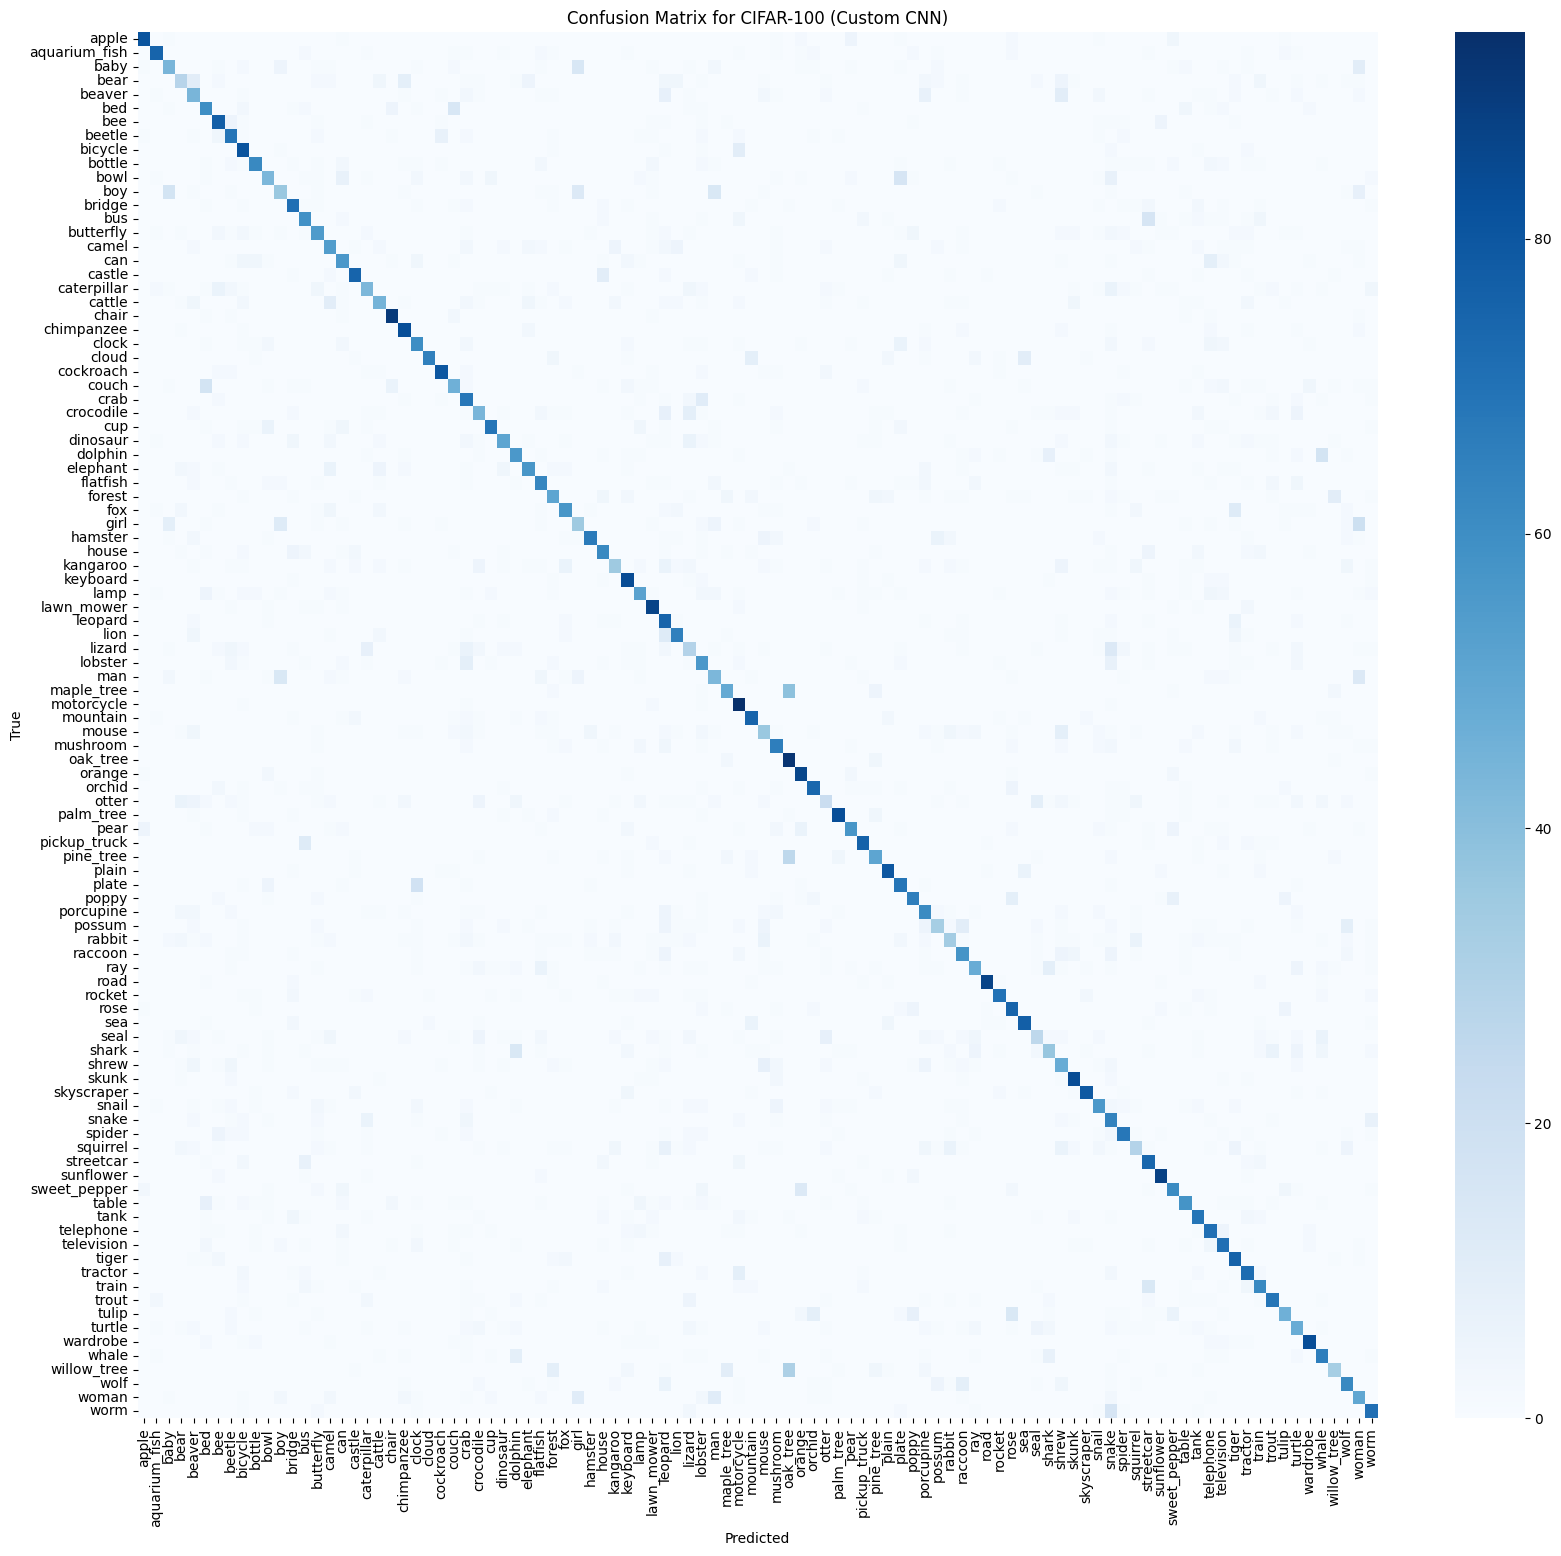


Plotting training history...


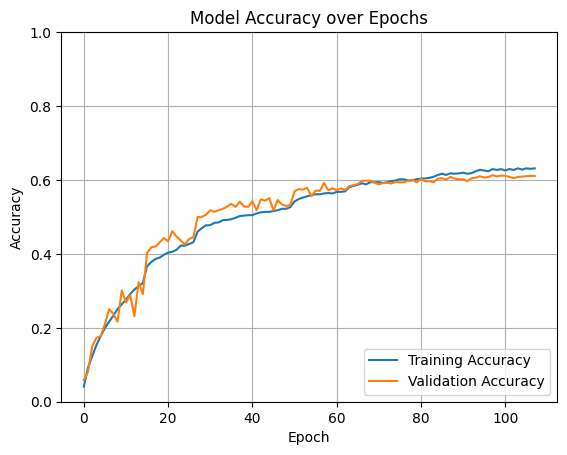

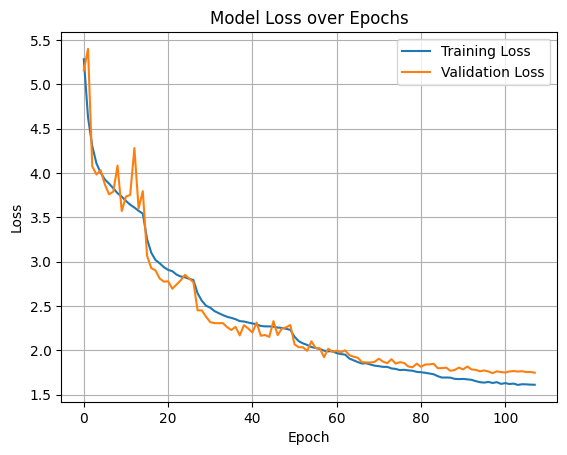

In [15]:
# Evaluate the model
print("\nEvaluating the model on the test dataset...")
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Generate predictions for classification report and confusion matrix
print("\nGenerating predictions for test set...")
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = y_test.flatten()  # Flatten to match y_pred shape

# CIFAR-100 fine label names (full list)
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=cifar100_fine_labels, digits=4))

# Compute and visualize confusion matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(20, 18))  # Large size for 100 classes
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=cifar100_fine_labels, yticklabels=cifar100_fine_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-100 (Custom CNN)')
plt.show()

# Plot training history
print("\nPlotting training history...")
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model

print("\nEvaluating the model on the test dataset...")

loss, accuracy = model.evaluate(
    test_dataset,
    verbose=1
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

print("\nPlotting training history...")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()